In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pykalman import KalmanFilter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune

First, let's make an RNN with a single input and a single output, with a connectivity given by an Erdős–Rényi graph.

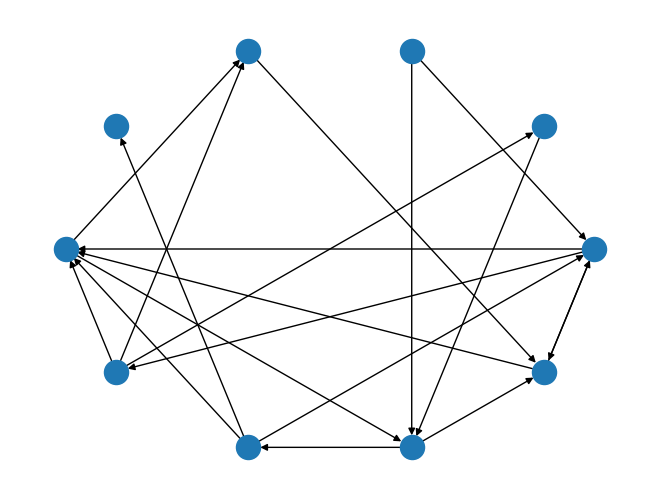

In [2]:
N_HIDDEN = 10
EDGE_PROB = 0.2
G = nx.fast_gnp_random_graph(N_HIDDEN, EDGE_PROB, directed=True)
nx.draw_circular(G)
plt.show()

In [3]:
# Credits:
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
# https://stackoverflow.com/questions/70269663/how-to-efficiently-implement-a-non-fully-connected-linear-layer-in-pytorch
# https://discuss.pytorch.org/t/custom-connections-in-neural-network-layers/3027/17
# https://discuss.pytorch.org/t/how-to-combine-multiple-criterions-to-a-loss-function/348/2

class PartialLinear(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.layer = nn.Linear(G.number_of_nodes(), G.number_of_nodes())
        self.mask = torch.from_numpy(nx.adjacency_matrix(G).todense())
        #prune.custom_from_mask(
        #    self.layer, name='weight', mask=self.mask
        #)

    def forward(self, inp):
        return self.layer(inp)

class PartialRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, G):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = PartialLinear(G)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, inp, hidden):
        hidden = self.i2h(inp) + self.h2h(hidden)
        output = self.h2o(hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.hidden_size, dtype=torch.float)

    def evaluate(self, input_tensors):
        hidden = self.initHidden()
        self.zero_grad()
        outputs = []
        for inp in input_tensors:
            output, hidden = self(inp, hidden)
            outputs.append(output)
        return outputs

    def train(self, output_tensors, input_tensors, learning_rate=0.001, criterion=None):
        if not criterion:
            criterion = nn.MSELoss()
        outputs = self.evaluate(input_tensors)
        losses = [criterion(o1, o2) for o1, o2 in zip(outputs, output_tensors)]
        loss = losses[-1]#sum(losses)
        loss.backward()
        for p in self.parameters():
            grad = torch.clamp(p.grad.data, -10, 10)
            print(grad)
            p.data.add_(grad, alpha=-learning_rate)
        return outputs, loss.item()

Now, let's try implementing a Kalman system. This will give us data to train our RNN with. The recursive equation of state will be
$$x_{t+1} = ax_t + b + \eta,$$
where $x_0, a, b \in \mathbb R$, $\eta \sim \mathcal N(0,\sigma^2)$, and $\sigma=1$.

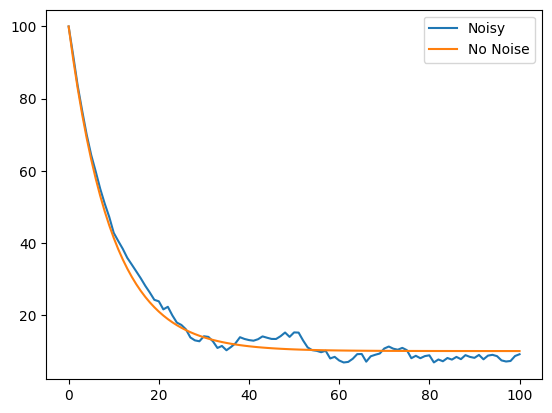

In [4]:
def make_proc(x0, a, b, num_steps=100, sigma=1, noisy=True):
    proc = []
    proc.append(x0)
    for _ in range(num_steps):
        prev = proc[-1]
        curr = a*prev + b
        if noisy:
            curr += np.random.normal(0,sigma)
        proc.append(curr)
    proc_torch = [torch.tensor([x], dtype=torch.float) for x in proc]
    return proc, proc_torch

noisy_proc, _ = make_proc(100, 0.9, 1)
pure_proc, _ = make_proc(100, 0.9, 1, noisy=False)

plt.plot(noisy_proc, label='Noisy')
plt.plot(pure_proc, label='No Noise')
plt.legend()
plt.show()

tensor([[ -5.6024],
        [  9.3933],
        [ -5.6095],
        [ -0.5589],
        [ -5.3872],
        [  9.8671],
        [  1.6456],
        [-10.0000],
        [ 10.0000],
        [  4.8303]])
tensor([ 0.3729,  2.6303,  0.5283,  1.4024, -1.3957,  1.7137,  0.4493, -3.1436,
         1.3113,  2.0171])
tensor([[  5.3130,  -2.3285,   0.5306,   7.5124,   8.3290,   4.5279,  -8.8069,
          -0.2347,  -8.5480,   0.8249],
        [  0.0825,   5.3153,  -4.4057,  10.0000,  10.0000,  10.0000, -10.0000,
           0.8160, -10.0000,  -7.4011],
        [  7.3884,  -2.9688,   1.3517,  10.0000,  10.0000,   6.6703, -10.0000,
          -0.6559, -10.0000,   1.3939],
        [  5.3084,  -0.1668,  -0.7558,  10.0000,  10.0000,  10.0000, -10.0000,
          -0.0525, -10.0000,  -1.8019],
        [  0.3943,  -2.9864,   2.4034, -10.0000, -10.0000, -10.0000,  10.0000,
          -0.5265,  10.0000,   3.9965],
        [ -3.7205,   5.5659,  -4.1023,  10.0000,  10.0000,  10.0000, -10.0000,
           0.9384,

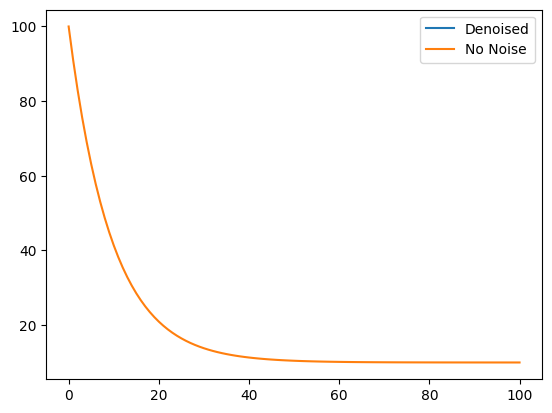

In [5]:
num_train_iters = 10
rnn = PartialRNN(1, N_HIDDEN, 1, G)
for _ in range(num_train_iters):
    x0, a, b = np.random.uniform(-100, 100), np.random.normal(0, 2), np.random.uniform(-10, 10)
    _, noisy_proc_torch = make_proc(x0, a, b)
    _, pure_proc_torch = make_proc(x0, a, b, noisy=False)
    rnn.train(pure_proc_torch, noisy_proc_torch)

x0 = 100
a = 0.9
b = 1
pure_proc, _ = make_proc(x0, a, b, noisy=False)
noisy_proc, noisy_proc_torch = make_proc(x0, a, b)
denoised_proc = rnn.evaluate(noisy_proc_torch)
denoised_proc = [t.item() for t in denoised_proc]
plt.plot(denoised_proc, label='Denoised')
plt.plot(pure_proc, label='No Noise')
plt.legend()
plt.show()